In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import random
import os
from PIL import Image
import time
from matplotlib import pyplot as plt

In [10]:
annotations_path = "../../data/Unet/annotations/"
data_path =  "../../data/Unet/images/"

annotations = os.listdir(annotations_path)
ant = Image.open(annotations_path + annotations[0])
print(np.shape(np.asarray(ant)))

(128, 128, 3)


In [11]:
images = os.listdir(data_path)
img = Image.open(data_path + images[0])
X = np.asarray(img)
print(np.shape(X))

annotations = os.listdir(annotations_path)
ant = Image.open(annotations_path + annotations[0])
Y_temp = np.asarray(ant)[:, :, 0]
Y = np.zeros_like(Y_temp)
print(np.shape(Y))

data = []
aa=(X, Y)

(128, 128, 3)
(128, 128)


In [12]:
class DataReader():
    def __init__(self):
        self.train_X = []
        self.train_Y = []
        self.test_X = []
        self.test_Y = []

        self.read_data()

    def read_data(self):
        images = os.listdir(data_path) 
        annotations = os.listdir(annotations_path)

        images.sort() #이름순으로 정렬
        annotations.sort()

        data = []

        for i in range(len(images)):
            img = Image.open(data_path + images[i])
            ant = Image.open(annotations_path + annotations[i])

            if img.mode != "RGB":
                img = img.convert("RGB") #PIL에서 제공하는 RGB변환 함수

            X = np.asarray(img) / 255.0 # np.shape(X) = 128*128*3 # range: 0~1

            Y_temp = np.asarray(ant)[:, :, 0]
            Y = np.zeros_like(Y_temp) 
            #zeros_like: zeros 와 같이 0-행렬를 만들지만, 이 함수는 행렬을 인수로 불러와서 진행
            #Y행렬의 사이즈는 128*128, 0으로 채워져있음
            Y[Y_temp > 127.5] = 1.0 #Y-temp의 값이 0-255 의 절반인 127.5를 넘는 픽셀만 1로 변경

            data.append((X, Y))
            
        random.shuffle(data)

        for i, el in enumerate(data): #i:index, el:data -> el[0]:RGB image, el[1]:bw mask
            if i < 0.8*len(data): #train:test=80:20
                self.train_X.append(el[0])
                self.train_Y.append(el[1])
            else:
                self.test_X.append(el[0])
                self.test_Y.append(el[1])

        self.train_X = np.asarray(self.train_X)
        self.train_Y = np.asarray(self.train_Y)
        self.test_X = np.asarray(self.test_X)
        self.test_Y = np.asarray(self.test_Y)
        
        # 읽어온 데이터의 정보를 출력
        print("Training X Size : " + str(self.train_X.shape))
        print("Training Y Size : " + str(self.train_Y.shape))
        print("Test X Size : " + str(self.test_X.shape))
        print("Test Y Size : " + str(self.test_Y.shape) + '\n\n')

In [13]:
input = keras.layers.Input((128,128,3))

# 첫 번째 Convolution Block
Conv1 = keras.layers.Conv2D(16, (3, 3), activation="relu", padding='same')(input) #3*3 conv
Conv1 = keras.layers.Conv2D(16, (3, 3), activation="relu", padding='same')(Conv1)
Pool1 = keras.layers.MaxPooling2D((2, 2)) (Conv1) #2*2 maxpolling

# 두 번째 Convolution Block
Conv2 = keras.layers.Conv2D(32, (3, 3), activation="relu", padding='same')(Pool1)
Conv2 = keras.layers.Conv2D(32, (3, 3), activation="relu", padding='same')(Conv2)
Pool2 = keras.layers.MaxPooling2D((2, 2))(Conv2)

# 세 번째 Convolution Block
Conv3 = keras.layers.Conv2D(64, (3, 3), activation="relu", padding='same')(Pool2)
Conv3 = keras.layers.Conv2D(64, (3, 3), activation="relu", padding='same')(Conv3)
Pool3 = keras.layers.MaxPooling2D((2, 2))(Conv3)

# 네 번째 Convolution Block
Conv4 = keras.layers.Conv2D(128, (3, 3), activation="relu", padding='same')(Pool3)
Conv4 = keras.layers.Conv2D(128, (3, 3), activation="relu", padding='same')(Conv4)
Pool4 = keras.layers.MaxPooling2D((2, 2))(Conv4)

# 다섯 번째 Convolution Block
Conv5 = keras.layers.Conv2D(256, (3, 3), activation="relu", padding='same')(Pool4)
Conv5 = keras.layers.Conv2D(256, (3, 3), activation="relu", padding='same')(Conv5)

# 첫 번째 Upsampling Block
Ups1 = keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2))(Conv5)
# UpSampling2D vs. Conv2DTranspose 차이
# UpSampling2D는 케라스 기준 내부적으로 resize_images() 를 호출함. 적은 해상도를 일부러 고해상도로 올림. 단순히 잡아 늘리는 역할
# Conv2DTranspose는 de-convolution 연산이 들어가서 해상도를 높임
Ups1 = keras.layers.Concatenate()([Ups1, Conv4])
# contraction path의 같은 레벨에 있던 이미지를 붙여넣음 
# 여기서 행렬사이즈는 64, 64, 32 -> 64, 64, 64  
Ups1_conv = keras.layers.Conv2D(128, (3, 3), activation="relu", padding="same")(Ups1)
Ups1_conv = keras.layers.Conv2D(128, (3, 3), activation="relu", padding="same")(Ups1_conv)

# 두 번째 Upsampling Block
Ups2 = keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding="same")(Ups1_conv)
Ups2 = keras.layers.Concatenate()([Ups2, Conv3])
Ups2_conv = keras.layers.Conv2D(64, (3, 3), activation="relu", padding="same")(Ups2)
Ups2_conv = keras.layers.Conv2D(64, (3, 3), activation="relu", padding="same")(Ups2_conv)

# 세 번째 Upsampling Block
Ups3 = keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding="same")(Ups2_conv)
Ups3 = keras.layers.Concatenate()([Ups3, Conv2])
Ups3_conv = keras.layers.Conv2D(32, (3, 3), activation="relu", padding="same")(Ups3)
Ups3_conv = keras.layers.Conv2D(32, (3, 3), activation="relu", padding="same")(Ups3_conv)

# 네 번째 Upsampling Block
Ups4 = keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding="same")(Ups3_conv)
Ups4 = keras.layers.Concatenate()([Ups4, Conv1])
Ups4_conv = keras.layers.Conv2D(16, (3, 3), activation="relu", padding="same")(Ups4)
Ups4_conv = keras.layers.Conv2D(16, (3, 3), activation="relu", padding="same")(Ups4_conv)

output = keras.layers.Conv2D(1, (1, 1))(Ups4_conv) #1*1 커널을 한개 사용하여 128*128 이미지 1개를 출력함


model = keras.Model(input, output)


In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 2320        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 16)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [16]:
model.compile(optimizer="adam", metrics=['accuracy'],loss='binary_crossentropy')

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

dr=DataReader()
EPOCHS = 10

history = model.fit(dr.train_X, dr.train_Y, epochs=EPOCHS,
                    validation_data=(dr.test_X, dr.test_Y),
                    callbacks=[early_stop],verbose = 1)

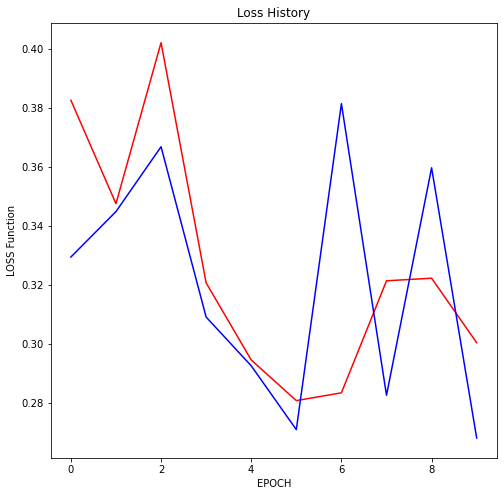

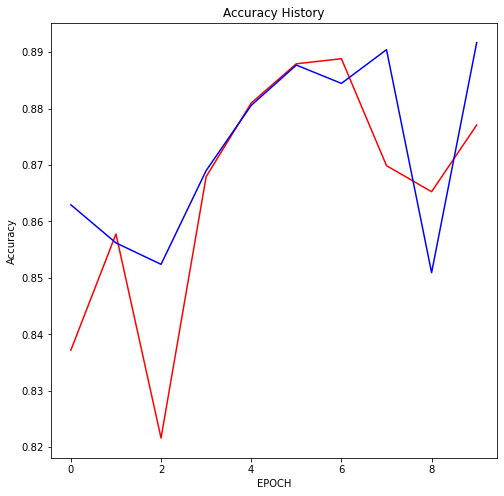

In [ ]:
train_history = history.history["loss"]
validation_history = history.history["val_loss"]
fig = plt.figure(figsize=(8, 8))
plt.title("Loss History")
plt.xlabel("EPOCH")
plt.ylabel("LOSS Function")
plt.plot(train_history, "red")
plt.plot(validation_history, 'blue')
fig.savefig("train_history.png")

train_history = history.history["accuracy"]
validation_history = history.history["val_accuracy"]
fig = plt.figure(figsize=(8, 8))
plt.title("Accuracy History")
plt.xlabel("EPOCH")
plt.ylabel("Accuracy")
plt.plot(train_history, "red")
plt.plot(validation_history, 'blue')
fig.savefig("accuracy_history.png")

In [ ]:
image=dr.test_X
mask_y=dr.test_Y

prediction = model.predict(image)[:, :, :, 0]
prediction[prediction < 0] = 0
pred_mask = (np.copy(image)*255).astype(np.uint8)[:, :, :, 0]
pred_mask[prediction > 0.5] = 255

mask = (np.copy(image)*255).astype(np.uint8)[:, :, :, 0]
mask[mask_y > 0.5] = 255

image = (image * 255).astype(np.uint8)

template = np.copy(image)[:, :, :, 0]

mask = np.stack((template, mask, template), axis=3)
pred_mask = np.stack((template, template, pred_mask), axis=3)

if "results" not in os.listdir():
    os.mkdir("results")

for i in range(len(image)):
    new_canvas = np.concatenate((image[i], mask[i], pred_mask[i]), axis=1)
    img = Image.fromarray(new_canvas)
    img.save("results/" + str(time.time()) + ".jpg")
    img.close()